# Conventional 16-QAM Demodulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Conventional demodulation
def demapper_sym(symbols_I, symbols_Q, Ns, threshold = 2.0):
   symbol = []
   for i in range(Ns):
        if symbols_I[i] <= -threshold and symbols_Q[i] >= threshold: #-3+3j
            symbol.append(0)
        elif symbols_I[i] <= -threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #-3+1j
            symbol.append(1)
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #-3-j
            symbol.append(3)
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= -threshold: #-3-3j
            symbol.append(2)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= threshold: #-1+3j
            symbol.append(4)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #-1+j
            symbol.append(5)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #-1-j
            symbol.append(7)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= -threshold: #-1-3j
            symbol.append(6)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= threshold: #1+3j
            symbol.append(12)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #1+j
            symbol.append(13)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #1-j
            symbol.append(15)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= -threshold: #1-3j
            symbol.append(14)
        elif symbols_I[i] >= threshold and symbols_Q[i] >= threshold: #3+3j
            symbol.append(8)
        elif symbols_I[i] >= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #3+1j
            symbol.append(9)
        elif symbols_I[i] >= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #3-1j
            symbol.append(11)
        elif symbols_I[i] >= threshold and symbols_Q[i] <= -threshold: #3-3j
            symbol.append(10)
   return np.array(symbol)

# Function tha calculate the bit error rate (BER) of two vectors with 4 bits
def bit_error_rate(y_pred, y_test):
    y_pred = ''.join([f"{sym:04b}" for sym in y_pred])
    y_test = ''.join([f"{sym:04b}" for sym in y_test])

    # Calculate the BER with the two strings
    return np.sum(np.array(list(y_pred)) != np.array(list(y_test)))/len(np.array(list(y_pred)))

# Function that calculate the symbol error rate (SER) of two vectors
def symbol_error_rate(y_pred, y_test):
    # Calculate the SER
    return np.sum(y_pred!=y_test)/len(y_pred)

# Add noise to the signal
def add_noise(signal, target_snr_db):
    X_avg_p = np.mean(signal**2)
    X_avg_db = 10 * np.log10(X_avg_p)
    noise_avg_db_r = X_avg_db - target_snr_db
    noise_avg_p_r = 10 ** (noise_avg_db_r / 10)
    mean_noise = 0
    noise_r = np.random.normal(mean_noise, np.sqrt(noise_avg_p_r), len(signal))
    return signal + noise_r


## Data preparation

In [3]:
# Generate 16-QAM random symbols
np.random.seed(0)
Ns = 100000
n = 16
symbols = np.random.randint(0, n, Ns)

In [4]:
mod_dict = {0:-3+3j, #0000
            1:-3+1j, #0001
            2:-3-3j, #0010
            3:-3-1j, #0011
            4:-1+3j, #0100
            5:-1+1j, #0101
            6:-1-3j, #0110
            7:-1-1j, #0111
            8:3+3j, #1000
            9:3+1j, #1001
            10:3-3j, #1010
            11:3-1j, #1011
            12:1+3j, #1100
            13:1+1j, #1101
            14:1-3j, #1110
            15:1-1j} #1111

In [5]:
X = np.array([mod_dict[i] for i in symbols])
Xr = np.real(X)
Xi = np.imag(X)

In [6]:
# Add noise to the signal
OSNR = [12, 13, 14, 15, 16, 17, 18, 19]
Xr_ch = [add_noise(Xr, noise) for noise in OSNR]
Xi_ch = [add_noise(Xi, noise) for noise in OSNR]

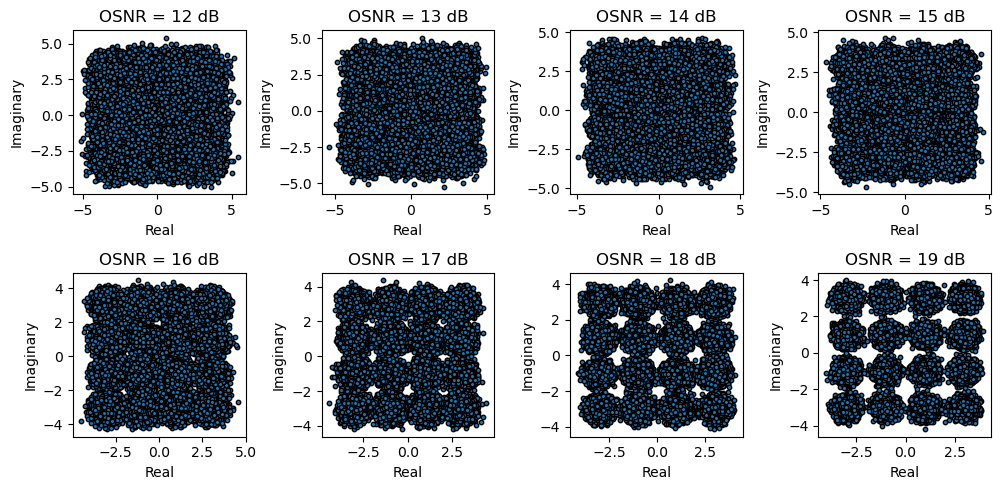

In [7]:
# Show the constellation in a grid of 2x4
plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.scatter(Xr_ch[i], Xi_ch[i], s=10, edgecolors='black')
    plt.title(f'OSNR = {OSNR[i]} dB')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
plt.tight_layout()
plt.show()

## Conventional demodulation

In [8]:
syms_rx = [demapper_sym(r, i, Ns) for r, i in zip(Xr_ch, Xi_ch)]

In [9]:
ber_conventional = []
ser_conventional = []
for i in range(8):
    ber_conventional.append(bit_error_rate(syms_rx[i], symbols))
    ser_conventional.append(symbol_error_rate(syms_rx[i], symbols))

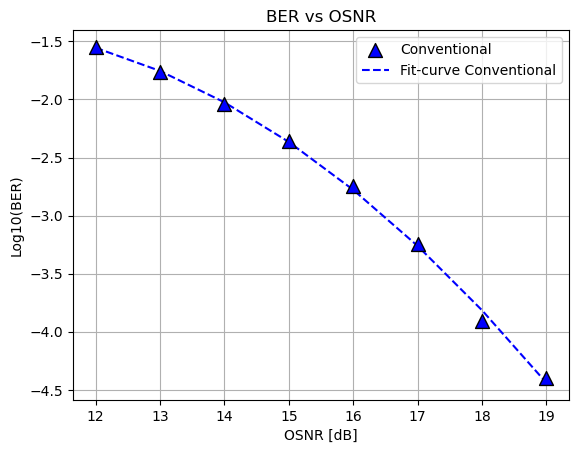

In [10]:
# Fit-curve of the BER
fit = np.polyfit(OSNR, np.log10(ber_conventional), 2)
fit_fn = np.poly1d(fit)

# Show the BER vs OSNR whit the fit-curve
plt.figure()
plt.scatter(OSNR, np.log10(ber_conventional), color='blue',
            marker='^', s=100, edgecolors='black', 
            zorder=3, clip_on=False, label='Conventional')
plt.plot(OSNR, fit_fn(OSNR), '--b', label='Fit-curve Conventional')
plt.title('BER vs OSNR')
plt.xlabel('OSNR [dB]')
plt.ylabel('Log10(BER)')
plt.grid()
plt.legend()
plt.show()